In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE  # For handling class imbalance
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load the dataset
file_path = '/content/insurance_data.csv'  # Update this path to your dataset
data = pd.read_csv(file_path)

In [5]:
# Drop irrelevant columns
irrelevant_columns = [
    'policy_number', 'insured_zip', '_c39', 'policy_bind_date',
    'incident_date', 'incident_location', 'auto_make', 'auto_model'
]
data = data.drop(columns=[col for col in irrelevant_columns if col in data.columns])

In [6]:
# Handle missing values
data = data.replace('?', np.nan)
data = data.fillna(data.mean(numeric_only=True))

# Encode categorical columns
label_encoder = LabelEncoder()
categorical_columns = data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column].astype(str))

In [7]:
# Separate features and target variable
X = data.drop('fraud_reported', axis=1)
y = data['fraud_reported']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Reshape for RNN and LSTM input
X_resampled = X_resampled.reshape((X_resampled.shape[0], 1, X_resampled.shape[1]))

In [9]:
# Split the balanced data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Convert target to categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [10]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_resampled), y=y_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Build the model
model = Sequential()

In [11]:
# Add RNN and LSTM layers
model.add(SimpleRNN(128, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
model.add(BatchNormalization())

model.add(LSTM(128, activation='relu', kernel_regularizer='l2', return_sequences=False))
model.add(BatchNormalization())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
# Add Dropout and Dense layers
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_regularizer='l2'))
model.add(Dense(2, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Add callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Train the model
history = model.fit(X_train, y_train_cat, epochs=100, validation_data=(X_test, y_test_cat),
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 465ms/step - accuracy: 0.5439 - loss: 3.9816 - val_accuracy: 0.6391 - val_loss: 3.5631 - learning_rate: 5.0000e-04
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6300 - loss: 3.4501 - val_accuracy: 0.7152 - val_loss: 3.2205 - learning_rate: 5.0000e-04
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6867 - loss: 3.0536 - val_accuracy: 0.7318 - val_loss: 2.9474 - learning_rate: 5.0000e-04
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7302 - loss: 2.7656 - val_accuracy: 0.7417 - val_loss: 2.7166 - learning_rate: 5.0000e-04
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7511 - loss: 2.5221 - val_accuracy: 0.7649 - val_loss: 2.5156 - learning_rate: 5.0000e-04
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7975 - loss: 2.3087 - val_accuracy: 0.7914 - val_loss: 2.3312 - learning_rate: 5.0000e-04
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.77

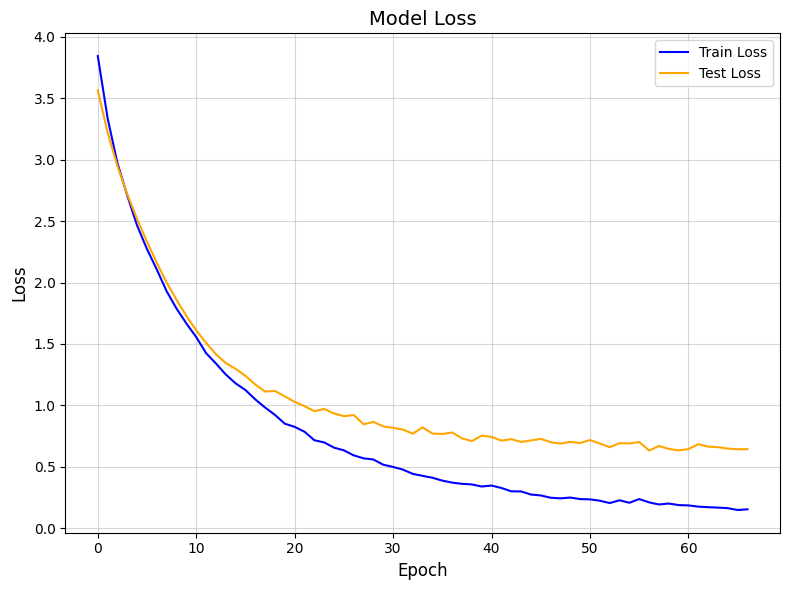

In [14]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history.get('loss', []), label='Train Loss', color='blue')
plt.plot(history.history.get('val_loss', []), label='Test Loss', color='orange')
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

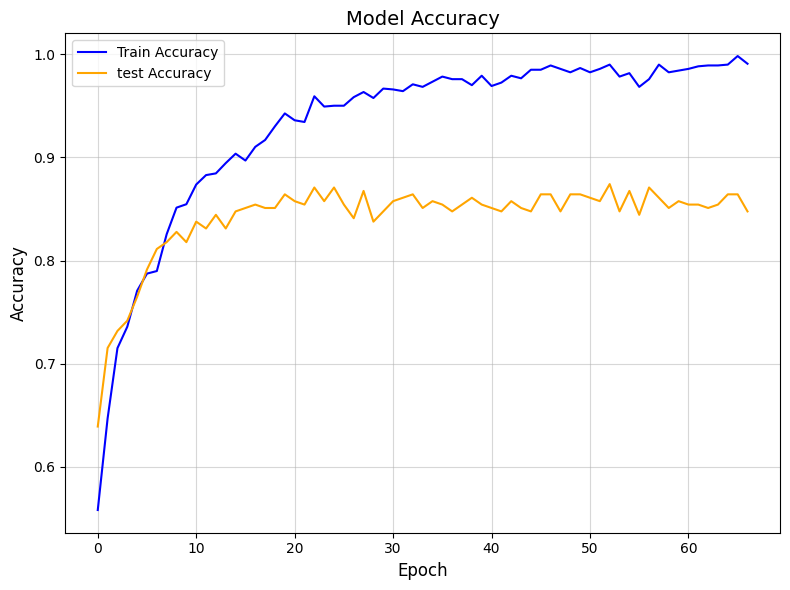

In [15]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history.get('accuracy', []), label='Train Accuracy', color='blue')
plt.plot(history.history.get('val_accuracy', []), label='test Accuracy', color='orange')
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


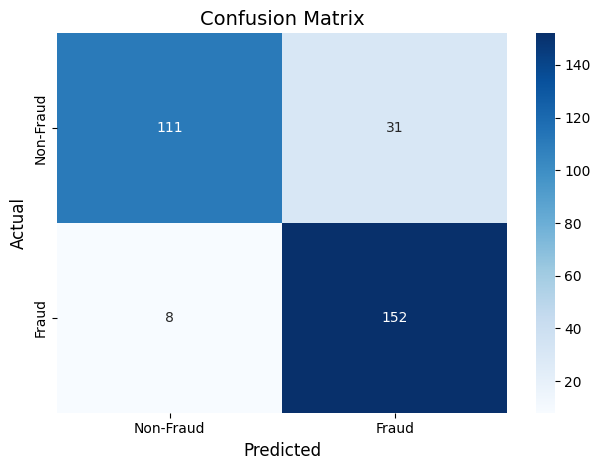

In [16]:
# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

In [17]:
# Classification Report
class_report = classification_report(y_test, y_pred_classes, target_names=['Non-Fraud', 'Fraud'])
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.93      0.78      0.85       142
       Fraud       0.83      0.95      0.89       160

    accuracy                           0.87       302
   macro avg       0.88      0.87      0.87       302
weighted avg       0.88      0.87      0.87       302

